In [13]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

## Group Assignment
### Team Number: 03
### Team Member Names: Sherry, Kelly, Ifan
### Team Strategy Chosen: SAFE

### Introduction 

Our safe portfolio generator follows the strategy to have two portfolios, before combining them altogether using the Monte Carlo algorithm. The first portfolio contains a number of stocks with the lowest betas and standard deviation, computed using a point system that will be explained further later on. The second portfolio contains a number of stocks that are negatively correlated to help offset any fluctuations. We also account for diversification, ensuring that there are not too many industries dominating the portfolio, to further reduce overall risk. We finally find the combined portfolio weighting using Monte Carlo. 

To start, we will filter through the given list of stocks to drop any stocks that do not meet our requirements. 

In [123]:
max_stocks = 25 #The total number of stocks we can possibly have
tickers_df = pd.read_csv('Tickers_Example.csv')
#When the CSV file is read, it takes the first ticker and makes it the name of the column, so we need to extract it
tickers_list = list(tickers_df.columns)
#Now add the rest of the tickers in after it:
tickers_list += tickers_df.iloc[:, 0].tolist()
tickers_num = len(tickers_list)

#Dates to pull closing data from, change as needed
start_date = '2020-01-01'
end_date = '2022-11-25'

# Dictionary of all the stocks
stocks_dict = {}
stocks_full_info = {}

# Function produces the daily closing prices of a stock
def get_closing_prices(ticker, start, end):
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start, end=end) #Daily
    return hist.Close

for i in range (tickers_num):
    stocks_dict[tickers_list[i]] = get_closing_prices(tickers_list[i], start_date, end_date)
    stocks_full_info[tickers_list[i]] = yf.Ticker(tickers_list[i])

# Create DataFrame
all_prices = pd.DataFrame(stocks_dict)

tickers_list_temp = tickers_list.copy()
#Some tickers are delisted, so we drop those columns entirely
for i in range (tickers_num):
    if all_prices[tickers_list[i]].isnull().all():
        all_prices.drop(columns=[tickers_list[i]], inplace=True)
        tickers_list_temp.remove(tickers_list[i]) #Getting rid of the tickers from our list too to match
        stocks_full_info.pop(tickers_list[i]) #Do the same to the dictionary of yfinance ticker objects

tickers_list = tickers_list_temp.copy()
tickers_num = len(tickers_list)

#Drop the rows at the bottom of the DataFrame where only a few stocks have values and where the dates are strange
all_prices = all_prices.dropna() 

print(tickers_list)

#Display the entire DataFrame, so that we can manually check to make sure the values are sensible
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(all_prices)

- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted
['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RY.TO', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TD.TO', 'TGT', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,BK,BLK,BMY,C,CAT,CL,CMCSA,COF,COP,COST,CSCO,CVS,GM,GOOG,JPM,KMI,KO,LLY,LMT,MO,MON,MRK,MS,MSFT,NEE,NKE,ORCL,OXY,PEP,PFE,PG,PM,PYPL,QCOM,RY.TO,SBUX,SLB,SO,SPG,T,TD.TO,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-16 00:00:00,124.265907,102.991287,114.960396,257.676697,45.678761,154.593002,140.325363,255.210007,36.480061,259.920013,43.974255,698.315796,58.655910,68.990318,217.884537,72.816864,55.796646,124.143257,52.917683,323.250336,47.165890,72.076767,56.989883,104.625999,146.212967,14.289573,48.974056,186.289154,332.890930,43.404179,9.785,69.581039,78.276802,234.083527,72.760933,142.769958,64.960358,27.963650,128.622879,33.759583,123.469933,80.504601,249.309998,129.892365,108.809334,107.442184,27.394434,57.139622,107.247574,19.613207,76.842155,174.705948,169.330276,347.556335,205.282013,155.261246,50.686958
2021-03-17 00:00:00,123.464317,97.601990,114.376953,258.410065,46.006893,156.786499,141.676712,263.589996,36.780502,264.149994,44.231030,703.289490,58.921234,69.244339,224.783005,72.759285,55.277508,127.196342,53.151501,325.166595,46.928490,71.059036,59.913212,104.554001,147.717850,14.558847,48.993176,182.219910,336.621368,43.702667,9.680,70.024910,79.528633,233.423767,70.425011,142.937759,64.348175,28.827276,128.248566,33.721893,122.971985,81.417351,251.470001,130.154785,109.203346,106.593002,27.638504,56.626534,108.208496,19.717846,76.935692,172.951233,171.442841,345.184418,205.863831,153.191986,51.298897
2021-03-18 00:00:00,119.278259,96.421936,114.853447,260.972015,46.151661,151.399506,139.620300,256.059998,37.739998,262.269989,44.411720,698.953247,59.063377,69.470131,221.944702,73.018456,53.710518,123.969353,49.924816,319.032532,46.339748,71.510300,59.134987,101.810997,150.156174,14.145959,48.352551,179.487503,343.746643,44.396225,9.770,69.997742,79.604492,227.200180,68.658585,141.309219,64.853455,26.425007,127.202385,33.703045,123.240105,82.658691,238.410004,126.102020,109.794334,103.852432,26.603647,56.346672,106.908958,19.626287,77.655930,174.124283,166.672806,354.858398,208.831070,152.762878,52.974648
2021-03-19 00:00:00,118.743858,96.096710,116.934441,257.930939,45.196205,153.748001,137.789124,255.820007,37.342632,267.070007,44.078869,704.660889,59.413986,68.689255,216.758804,71.972176,53.316357,122.152946,49.195297,324.890045,46.510674,70.262131,59.683735,102.160004,147.765488,14.289573,48.582027,179.838837,340.505249,44.378666,9.750,70.215141,78.656143,226.835831,68.378670,135.703033,64.387039,27.894161,129.093185,33.476917,122.579369,82.556938,241.279999,127.336304,109.325287,102.617233,26.408390,55.693638,106.790009,19.462790,77.094711,181.821777,168.221420,358.318268,204.409317,151.895096,51.976723
2021-03-22 00:00:00,122.108551,98.401108,118.120804,259.319489,44.617134,155.543503,137.044891,251.229996,36.499447,272.339996,42.994728,705.897095,60.058338,67.701393,217.461166,72.730476,54.191189,120.983879,48.858601,330.401855,47.764126,70.540558,57.967651,101.929497,143.793701,14.163912,48.763699,181.351395,342.988983,45.335590,9.700,70.215141,77.688820,232.389786,69.199142,136.472885,64.445335,27.258850,132.260529,33.919762,124.657318,83.232201,244.384995,130.319992,108.799965,103.804176,26.994160,55.684307,105.472168,19.613207,76.832787,182.296799,172.159760,359.572815,200.016647,153.582947,51.063538
2021-03-23 00:00:00,121.267365,97.416161,117.167831,260.131042,43.410740,156.875000,133.255264,241.250000,35.762863,267.209991,42.195889,692.038330,59.338173,66.713531,209.985413,74.631058,53.970074,118.268944,48.362904,336.180359,47.488743,69.033165,56.032074,102.648003,142.355499,14.074154,49.136597,179.243561,339.105133,44.343548,9.660,69.091866,75.033440,233.955521,71.448166,135.337814,65.368484,26.395226,133.853806,33.316738,126.974655,81.446930,243.770004,128.794159,108.668633,102.530388,26.037403,56.561230,101.042801,19.619747,76.439934,183.149902,170.897964,361.180267,201.742676,152.438644,50.442192
2021-03-24 00:

In [124]:
#--------------------------------------------------------------------------
#This block of code takes several minutes to run (with 50-something stocks)
#--------------------------------------------------------------------------

# Remove invalid stocks per assignment requirement (ones outside of the U.S & ones with average monthly volume of less than 200,000 shares)

df_diff_market = pd.DataFrame()

#Function runs for approx. 9 min for yfinance API
def filter_market(df):
    df_transposed = df.T
    mkt_lst = []
    
    for i in range(len(df_transposed)):
        # Populate market list
        temp = stocks_full_info[tickers_list[i]]
        mkt_lst.append(temp.info['market'])
    
    df_transposed['Market'] = mkt_lst
    
    # Drops the stocks in markets that are not in the U.S
    df_transposed.drop(df_transposed[df_transposed.Market != "us_market"].index, inplace=True)
    df_transposed = df_transposed.drop('Market', axis=1)

    return_df = df_transposed.T

    return return_df

df_diff_volume=[]

# Drops the stocks with volumes less than average monthly volume of 200,000
def filter_volume(df):

    start = "2022-01-01"
    end = "2022-10-31"

    df_transposed = df.T
    volume_lst = []

    for i in range(len(df_transposed)):
        ticker_hist = stocks_full_info[tickers_list[i]].history(start=start, end=end, interval="1mo")
        volume_hist = ticker_hist.loc[(ticker_hist.index >= pd.to_datetime(start)) & (ticker_hist.index <= pd.to_datetime(end))]
        volume_lst.append(volume_hist['Volume'].mean())

    # Drops the stocks with volumes less than average monthly volume of 200,000
    df_transposed["Volume"] = volume_lst

    df_transposed.drop(df_transposed[df_transposed.Volume < 200000].index, inplace=True)
    df_transposed = df_transposed.drop('Volume', axis=1)
    return_df = df_transposed.T

    return return_df

# Drops stocks with more than specified number of NaN values
max_number_of_nans = 20
all_prices = all_prices.loc[:, (all_prices.isnull().sum(axis=0) <= max_number_of_nans)]

all_prices = filter_market(all_prices)
display(all_prices)

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SLB,SO,SPG,T,TGT,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-16,124.265907,102.991287,114.960396,257.676697,45.678761,154.593002,140.325363,255.210007,36.480061,259.920013,...,27.394434,57.139622,107.247574,19.613207,174.705948,169.330276,347.556335,205.282013,155.261246,50.686958
2021-03-17,123.464317,97.601990,114.376953,258.410065,46.006893,156.786499,141.676712,263.589996,36.780502,264.149994,...,27.638504,56.626534,108.208496,19.717846,172.951233,171.442841,345.184418,205.863831,153.191986,51.298897
2021-03-18,119.278259,96.421936,114.853447,260.972015,46.151661,151.399506,139.620300,256.059998,37.739998,262.269989,...,26.603647,56.346672,106.908958,19.626287,174.124283,166.672806,354.858398,208.831070,152.762878,52.974648
2021-03-19,118.743858,96.096710,116.934441,257.930939,45.196205,153.748001,137.789124,255.820007,37.342632,267.070007,...,26.408390,55.693638,106.790009,19.462790,181.821777,168.221420,358.318268,204.409317,151.895096,51.976723
2021-03-22,122.108551,98.401108,118.120804,259.319489,44.617134,155.543503,137.044891,251.229996,36.499447,272.339996,...,26.994160,55.684307,105.472168,19.613207,182.296799,172.159760,359.572815,200.016647,153.582947,51.063538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17,150.720001,152.160004,102.559998,287.140015,59.439999,94.849998,150.639999,172.779999,37.169998,302.049988,...,52.830002,64.239998,115.790001,18.950001,162.009995,175.360001,515.309998,209.820007,176.059998,42.770000
2022-11-18,151.289993,154.979996,103.870003,286.500000,59.820000,94.139999,152.500000,173.889999,37.189999,302.890015,...,53.439999,65.570000,117.900002,18.969999,162.880005,175.179993,530.000000,210.580002,178.970001,43.380001
2022-11-21,148.009995,157.110001,103.879997,287.019989,60.110001,92.459999,152.809998,172.940002,37.310001,301.630005,...,52.270000,65.730003,117.180000,18.840000,158.020004,172.399994,517.190002,212.270004,180.610001,43.389999


In [125]:
# Update previously defined variables
all_prices = filter_market(all_prices)
all_prices = filter_volume(all_prices)

tickers_list = []
for col in all_prices.columns:
     tickers_list.append(col)

stocks_full_info.clear()
for i in range (len(tickers_list)):
    stocks_full_info[tickers_list[i]] = yf.Ticker(tickers_list[i])

tickers_num = len(tickers_list)

## Beta and Standard Deviation

Since we chose the safe investment strategy, we want to make sure the stocks we choose have the lowest volatility and risk. To do that, we can use two measures of a stock's volatility: standard deviation and beta. First, we have to define a function that calculates the beta value of a stock. In other words, how volatile it is compared to the market. We decided to use the S&P 500 as the market to compare all our stocks to, as it's one of the more reliable value weighted indexes in the United States. 

Beta essentially calculates how a stock moves in relation to the market. If it is negative, it moves opposite the market, on average, whereas if it's positive, it moves with the market. A value of 1 means that the stock perfectly follows the movement of the market; larger than 1 and it means the stock is more sensitive to market movements, moving up and down more than the market, in the same direction. If a stock has a beta closer to 0, then that means it's less sensitive to changes in the market, which is better for us since we want a portfolio that is fairly stable. The lower our beta, the better, as it is very unlikely that we'll have any stocks that move opposite the market. Even if we happen to do, there will still be far more stocks with positive betas, so a stock with a negative beta will help balance out the market risk from all our other stocks. 

Another key statistic we need in order to determine which stocks are the safest and least volatile is the standard deviation of percentage returns. Similarly to beta, we wish to select stocks with a low standard deviation. This way, we are able to find the stocks that have lower volatility as they have a smaller percentage return. As such, we are able to construct a portfolio with lower risk. 


In [126]:
#Function to get the beta of a stock against a given market
def stock_beta(stock_ticker, market_index):
    
    #Get basic info on both the stock and the market
    index_ticker = yf.Ticker(market_index)
    stock_ticker_object = yf.Ticker(stock_ticker)
    stock_hist = stock_ticker_object.history(start=start_date, end=end_date)
    MarketIndex_hist = index_ticker.history(start=start_date, end=end_date)
    
    #Get the closing prices of both the stock and market
    prices = pd.DataFrame(stock_hist['Close'])
    prices.columns = [stock_ticker]
    prices[market_index] = MarketIndex_hist['Close']
    
    #Daily returns of both stock and market
    daily_returns = prices.pct_change()
    daily_returns.drop(index=daily_returns.index[0], inplace=True) #Drop the first entry since it's NaN
    
    #Calculate market variance
    MarketVar = daily_returns[market_index].var()
    
    #Now calculate the beta by taking the covariance
    beta = daily_returns.cov() / MarketVar
    
    return beta.iat[0,1] #To get the value we need, don't care about the others

In [127]:
#--------------------------------------------------------------------------
#This block of code takes a few seconds to run (with 50-something stocks)
#--------------------------------------------------------------------------
daily_returns = all_prices.pct_change()

#New DataFrame to hold our std and beta stats
stats_df = pd.DataFrame(daily_returns.std())
stats_df.columns = ['std']

# Calculate BETA against S&P500
MarketIndex = '^GSPC' #This is the symbol yfinance uses for the S&P 500
beta_list = []

for i in range (tickers_num):
    beta_list.append(stock_beta(tickers_list[i], MarketIndex))

stats_df['beta'] = beta_list
#stats_df

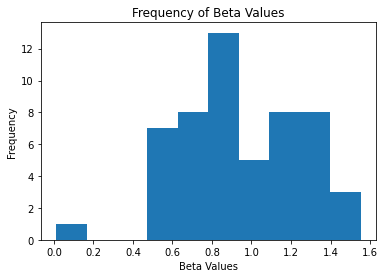

In [128]:
# Plot the histogram
plt.hist(stats_df['beta'])

# Title and Axes Labels
plt.title('Frequency of Beta Values')
plt.xlabel('Beta Values')
plt.ylabel('Frequency')

plt.show()

From the graph above, we can see that most of our beta values lie around the 1.0 mark, which makes sense because that's the average market movement; you'd expect most stocks to move roughly similarly to the market, as otherwise the market would not be moving in that direction. 

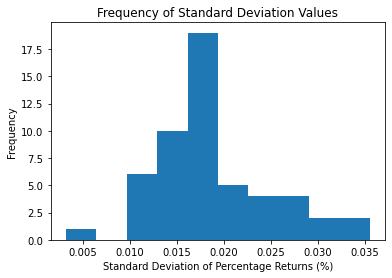

In [129]:
# Plot the histogram
plt.hist(stats_df['std'])

# Title and Axes Labels
plt.title('Frequency of Standard Deviation Values')
plt.xlabel('Standard Deviation of Percentage Returns (%)')
plt.ylabel('Frequency')

plt.show()

 In the graph above, you can see a histogram of the standard deviation of percentage returns on all of our stocks. We want to select the stocks with the smallest values, and avoid those on the upper end of the spectrum, since we want to avoid having too much risk in our portfolio. 

## Point System

Since we have two different measures for risk and stock volatility, we needed a way to combine them together a low beta didn't necessarily mean a low standard deviation, and the same for the other way around. We didn't necessarily want to prioritize one over the other by filtering our stocks by one statistic before filtering by the other, so we decided on a points system. We would sort all our stocks based on standard deviation, and again by beta, going from smallest to largest. Then, we gave points to each stock depending on where they ranked in our sorted list, giving the stock with the lowest standard deviation and lowest beta the highest number of points, and those with the highest values the lowest number of points. Then, we added those points together and resorted the series to get the final list of stocks from safest to riskiest, based purely on beta and standard deviation.

## Diversification


As we learned from Assignment 3, diversification reduces the overall risk of a portfolio. So, when we choose the stocks with the highest number of points based on standard deviation and beta, we also need to consider the industries that the stocks are from. Even if some stocks have low standard deviation and beta values, we must consider the industry that they are a part of. Thus, we have implemented a process that selects stocks based on standard deviation and beta values, while also taking into account the importance of diversification across industries. After a select number of stocks have been chosen from an industry, we no longer add the next stock from that same industry. Instead, we introduce stocks from other industries. This way, if any external event were to affect one particular industry more than the others, our portfolio would overall experience less fluctuations. By accounting for non-systematic risk, we are further ensuring that our final portfolio is safe. 

In [130]:
#Get a pandas series of the beta and sd, sorted in ascending order, then put that in a DataFrame
beta_df = pd.DataFrame(stats_df['beta'].sort_values(ascending=True))
std_df = pd.DataFrame(stats_df['std'].sort_values(ascending=True))

#Now we give each stock points in each category using a list
std_points = []
beta_points = []
for i in range (tickers_num):
    std_points.append(tickers_num - i) #So the stocks with the lowest std get the highest number of points
    beta_points.append(tickers_num - i) #So the stocks with the lowest beta get the highest number of points

#Add our lists to our DataFrames as new columns
beta_df['points'] = beta_points
std_df['points'] = std_points

#Store all the necessary points values we need, adding the points from beta and std together
total_points = pd.DataFrame(std_df['points'])
total_points.columns = ['std']
total_points['beta'] = pd.DataFrame(beta_df['points'])
total_points['total'] = total_points['std'] + total_points['beta']

#Now we isolate the total points and sort that series from highest to lowest before turning it back into a DataFrame
#Since we want to prioritize the stocks with the highest number of total points
final_points = pd.DataFrame(total_points['total'].sort_values(ascending=False))
final_points.reset_index(inplace=True)
final_points.columns = ['tickers', 'points']
#final_points

In [131]:
#----------------------------------------------------------------------------
#This block of code takes several minutes to run (with 50-something stocks)
#----------------------------------------------------------------------------
selected_tickers = []
sector_count = {}
sector_max = 5

for i in range (tickers_num):
    #We only want choose the maximum number of stocks we can (initiated in the very beginning of the code), not the
    # total number of stocks we have, so if we have enough stocks, do nothing
    if len(selected_tickers) < max_stocks: 
        temp = stocks_full_info[tickers_list[i]]
        sector = temp.info['sector']
        if sector in sector_count: #If there is a key in sector_count that matches the sector of our stock
            #If our current number of stocks is less than our maximum, then we add it, otherwise we just skip over it
            # and do nothing
            if sector_count[sector] < sector_max: 
                selected_tickers.append(final_points.tickers[i])
                sector_count[sector] += 1
        else: #So if there is no sector in our dictionary that matches that of the stock
            selected_tickers.append(final_points.tickers[i])
            sector_count[sector] = 1

selected_tickers

['MON',
 'BMY',
 'CL',
 'KO',
 'PG',
 'ABBV',
 'MRK',
 'PEP',
 'MO',
 'PM',
 'SO',
 'LMT',
 'CVS',
 'PFE',
 'ABT',
 'COST',
 'UNP',
 'UNH',
 'NEE',
 'CMCSA',
 'CSCO',
 'UPS',
 'JPM',
 'ACN',
 'ORCL']

In [132]:
sector_count

{'Technology': 3,
 'Healthcare': 5,
 'Financial Services': 5,
 'Consumer Cyclical': 2,
 'Industrials': 3,
 'Consumer Defensive': 3,
 'Communication Services': 2,
 'Energy': 2}

In [133]:
selected_ticker_prices = pd.DataFrame()
selected_portfolio = pd.DataFrame()
selected_ticker_returns = pd.DataFrame()
selected_ticker_points = []
selected_ticker_weights = []
shares_per_stock = []
investment = 500000 #500,000

#Get the number of points associated with each of our chosen tickers
for i in range (len(selected_tickers)):
    selected_ticker_points.append(total_points.total[selected_tickers[i]])

#Calculate the weighting that should be given to each of our selected tickers, based on how their points compare to 
# that of the other chosen stocks
for i in range (len(selected_tickers)):
    selected_ticker_weights.append(selected_ticker_points[i] / sum(selected_ticker_points))
    selected_ticker_prices[selected_tickers[i]] = all_prices[selected_tickers[i]]
    selected_ticker_returns[selected_tickers[i]] = daily_returns[selected_tickers[i]]
    shares_per_stock.append((investment * selected_ticker_weights[i]) / selected_ticker_prices.iloc[0, i])
    selected_portfolio[selected_tickers[i]] = shares_per_stock[i] * selected_ticker_prices[selected_tickers[i]]

selected_portfolio['total'] = selected_portfolio.sum('columns')
selected_ticker_prices


,MON,BMY,CL,KO,PG,ABBV,MRK,PEP,MO,PM,...,COST,UNP,UNH,NEE,CMCSA,CSCO,UPS,JPM,ACN,ORCL
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-16,9.785,58.655910,72.816864,48.974056,123.469933,102.991287,69.581039,128.622879,43.404179,80.504601,...,323.250336,205.282013,347.556335,72.760933,55.796646,47.165890,155.261246,146.212967,257.676697,64.960358
2021-03-17,9.680,58.921234,72.759285,48.993176,122.971985,97.601990,70.024910,128.248566,43.702667,81.417351,...,325.166595,205.863831,345.184418,70.425011,55.277508,46.928490,153.191986,147.717850,258.410065,64.348175
2021-03-18,9.770,59.063377,73.018456,48.352551,123.240105,96.421936,69.997742,127.202385,44.396225,82.658691,...,319.032532,208.831070,354.858398,68.658585,53.710518,46.339748,152.762878,150.156174,260.972015,64.853455
2021-03-19,9.750,59.413986,71.972176,48.582027,122.579369,96.096710,70.215141,129.093185,44.378666,82.556938,...,324.890045,204.409317,358.318268,68.378670,53.316357,46.510674,151.895096,147.765488,257.930939,64.387039
2021-03-22,9.700,60.058338,72.730476,48.763699,124.657318,98.401108,70.215141,132.260529,45.335590,83.232201,...,330.401855,200.016647,359.572815,69.199142,54.191189,47.764126,153.582947,143.793701,259.319489,64.445335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17,9.995,77.160004,75.290001,60.709999,140.869995,152.160004,102.309998,180.029999,43.669998,95.160004,...,521.320007,209.820007,515.309998,81.933891,34.259998,46.590000,176.059998,132.539993,287.140015,79.199997
2022-11-18,9.995,77.449997,76.459999,61.139999,142.570007,154.979996,104.230003,181.330002,44.200001,96.279999,...,523.669983,210.580002,530.000000,82.779594,34.500000,47.790001,178.970001,133.839996,286.500000,79.730003
2022-11-21,9.995,78.959999,76.919998,62.080002,144.380005,157.110001,105.610001,184.820007,44.799999,96.900002,...,523.369995,212.270004,517.190002,83.177574,34.349998,47.619999,180.610001,133.050003,287.019989,79.820000


In [134]:
selected_portfolio

,MON,BMY,CL,KO,PG,ABBV,MRK,PEP,MO,PM,...,UNP,UNH,NEE,CMCSA,CSCO,UPS,JPM,ACN,ORCL,total
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-16,27082.268779,25804.803270,25549.310169,24271.844660,24016.351559,24016.351559,24016.351559,22738.886050,22483.392948,21461.420542,...,18140.010220,18140.010220,16607.051610,16096.065406,15840.572305,15585.079203,12774.655084,12774.655084,12263.668881,500000.000000
2021-03-17,26791.658061,25921.528495,25529.107366,24281.320285,23919.494886,22759.631048,24169.556385,22672.712219,22638.010247,21704.747218,...,18191.423286,18016.212702,16073.897626,15946.305785,15760.841958,15377.367515,12906.136986,12811.012746,12148.096782,497706.240141
2021-03-18,27040.754470,25984.062322,25620.042733,23963.822579,23971.647337,22484.456463,24160.179077,22487.760797,22997.273611,22035.671578,...,18453.627226,18521.126844,15670.726199,15494.264781,15563.114337,15334.293811,13119.173821,12938.024761,12243.486973,498350.037048
2021-03-19,26985.398540,26138.307507,25252.933682,24077.552762,23843.126411,22408.617641,24235.215972,22822.030228,22988.178010,22008.545564,...,18062.893317,18701.707830,15606.838062,15380.558218,15620.519213,15247.186044,12910.299121,12787.259457,12155.433824,497258.017383
2021-03-22,26847.011353,26421.780654,25518.999272,24167.590102,24247.311991,22945.975936,24235.215972,23381.976136,23483.865496,22188.561256,...,17674.729388,18767.186417,15794.103841,15632.927429,16041.488729,15416.612037,12563.283370,12856.098607,12166.439387,501385.538761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17,27663.492853,33945.406322,26417.061652,30088.250394,27400.868023,35481.915406,35312.965852,31827.009773,22621.087649,25368.349685,...,18541.015955,26895.578266,18700.699767,9883.231559,15647.160907,17672.851931,11580.044744,14235.337126,14951.927188,600449.953550
2022-11-18,27663.492853,34072.984594,26827.579827,30301.361201,27731.540357,36139.504243,35975.668431,32056.833747,22895.629340,25666.924997,...,18608.173851,27662.293665,18893.724167,9952.466593,16050.178829,17964.957262,11693.626261,14203.607573,15051.985490,607357.872595
2022-11-21,27663.492853,34737.287777,26988.980067,30767.232215,28083.606134,36636.196221,36451.983523,32673.822247,23206.428942,25832.209211,...,18757.513100,26993.701374,18984.559589,9909.194559,15993.083993,18129.579929,11624.604396,14229.386700,15068.975626,611102.768010


In [135]:
top_number_of_stocks = 30
top_stocks_returns = pd.DataFrame()
top_stocks_tickers = []

for i in range (top_number_of_stocks):
    top_stocks_tickers.append(final_points['tickers'])
    top_stocks_returns[top_stocks_tickers[i]] = daily_returns[top_stocks_tickers[i]]

top_stocks_returns

,MON,BMY,CL,KO,PG,ABBV,MRK,PEP,MO,PM,...,COP,AXP,SPG,SLB,QCOM,GM,COF,PYPL,BA,OXY
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-17,-0.010731,0.004523,-0.000791,0.000390,-0.004033,-0.052328,0.006379,-0.002910,0.006877,0.011338,...,0.004419,0.009630,0.008960,0.008909,0.002020,0.051296,0.024593,0.008664,0.032836,0.030884
2021-03-18,0.009298,0.002412,0.003562,-0.013076,0.002180,-0.012090,-0.000388,-0.008157,0.015870,0.015247,...,-0.060707,-0.014515,-0.012010,-0.037443,-0.031138,-0.012989,-0.025370,-0.051935,-0.028567,-0.083333
2021-03-19,-0.002047,0.005936,-0.014329,0.004746,-0.005361,-0.003373,0.003106,0.014865,-0.000396,-0.001231,...,-0.014612,-0.013115,-0.001113,-0.007339,0.009788,0.009280,-0.014652,0.012038,-0.000937,0.055597
2021-03-22,-0.005128,0.010845,0.010536,0.003739,0.016952,0.023980,0.000000,0.024535,0.021563,0.008179,...,-0.006844,-0.005401,-0.012340,0.022181,0.023432,-0.028753,-0.009571,0.012869,-0.017942,-0.022776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17,0.000000,0.013263,-0.009472,0.003139,-0.006138,0.001910,0.023817,0.009533,0.002065,0.004751,...,0.015088,-0.012650,0.001730,-0.003019,0.017643,0.004419,-0.022799,-0.016085,0.000521,-0.006534
2022-11-18,0.000000,0.003758,0.015540,0.007083,0.012068,0.018533,0.018767,0.007221,0.012137,0.011770,...,-0.019819,0.012347,0.018223,0.011546,0.008058,0.029244,-0.004827,-0.008407,0.006424,-0.002939
2022-11-21,0.000000,0.019496,0.006016,0.015375,0.012696,0.013744,0.013240,0.019247,0.013575,0.006440,...,-0.024108,0.002033,-0.006107,-0.021894,-0.029471,-0.006286,0.023747,-0.050518,-0.005463,-0.023298


### Correlation 
We will calculate the correlation between two stocks, given by the following formula: 
\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

It describes the relationship between two two and how they move together. This calculation is expressed numerically as the correlation coefficient, which has a value between -1 and 1, where 1 represents a perfect positive correlation and -1 represents a perfect negative correlation. When two stocks are postively correlated, it implies that as one stock moves up or down, the other moves in the same direction. Conversely, when two stocks are negatively correlated, it implies that the two move in opposite directions. Zero correlation implies that there is no relationship between the stocks at all. 

Since we are creating a safe portfolio, we wish to reduce risk. Thus, we want to find a negative correlation between our stocks to help counteract any fluctuations within the protfolio. We take the list of stocks that have low standard deviations and betas, so that the overall portfolio is not affected by the volatility of these stocks. We then wish to find the most negatively correlated stocks in that list to discover which best complement the portfolio. Furthermore, the inclusion of negatively correlated stocks is used to account for non-systematic risks. If two stocks are very positively correlated, it is expected that the external event that affected one stock, is likely to affect the other. Therefore, to reduce risk, we include a small number of stocks that have a negative correlation with each other. 

We are able to find the correlation between all the stocks in our sorted list by using a correlation matrix:

In [136]:
#returns the redundant pairs in the matrix, such as AAPL and AAPL or AAPL and ABBV with AABV and AAPL
def get_redundant_pairs(df):
    to_drop = set()
    cols = df.columns

    #itereate through the rows and the columns to drop any redundant pairs
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            to_drop.add((cols[i], cols[j]))

    return to_drop

def get_neg_correlations(df):
    #unstack to make it easier to read, outputting a series 
    sorted_corr = df.corr().unstack()
    #dropping the redundant pairs 
    to_drop = get_redundant_pairs(df)
    sorted_corr = sorted_corr.drop(labels=to_drop).sort_values(ascending=True)
    return sorted_corr

print("\nNegative Correlations")
get_neg_correlations(top_stocks_returns)


Negative Correlations


MON   USB    -0.048533
PG    OXY    -0.038462
CL    OXY    -0.037095
MON   COF    -0.032545
      PM     -0.029213
                ...   
KO    PEP     0.810738
MSFT  GOOG    0.814204
JPM   C       0.818661
BAC   C       0.830908
JPM   BAC     0.901561
Length: 1378, dtype: float64

In [137]:
temp = pd.DataFrame(get_neg_correlations(top_stocks_returns))
neg_corr = temp.reset_index()
neg_corr.rename(columns = {'level_0':'Ticker 1', 'level_1':'Ticker 2'}, inplace = True)
display(neg_corr)

#Function to remove any instances of a ticker from a DataFrame set up like neg_corr
def remove_instances(ticker1, df):
    #Loop through all rows of the DataFrame
    new_df = df.copy()
    index_to_drop = []
    for i in range (len(df.index)):
        if ticker1 == new_df.iloc[i, 0]:
            index_to_drop.append(i)
        elif ticker1 == new_df.iloc[i, 1]:
            index_to_drop.append(i)
        
    new_df.drop(labels=index_to_drop, axis=0, inplace=True)
    return new_df


,Ticker 1,Ticker 2,0
0,MON,USB,-0.048533
1,PG,OXY,-0.038462
2,CL,OXY,-0.037095
3,MON,COF,-0.032545
4,MON,PM,-0.029213
...,...,...,...
1373,KO,PEP,0.810738
1374,MSFT,GOOG,0.814204
1375,JPM,C,0.818661
1376,BAC,C,0.830908


In [41]:
corr_stocks_number = 3 
corr_tickers = []
temp_df = neg_corr.copy()
temp_df.reset_index(drop=True, inplace=True)

for i in range (corr_stocks_number):
    print(temp_df)
    corr_tickers.append(temp_df.iloc[0, 0])
    tick1 = corr_tickers[2*i]
    
    corr_tickers.append(temp_df.iloc[0, 1])
    
    tick2 = corr_tickers[2*i + 1]
    temp_df = remove_instances(tick1, temp_df)
    temp_df.reset_index(drop=True, inplace=True)
    temp_df = remove_instances(tick2, temp_df)
    temp_df.reset_index(drop=True, inplace=True)

corr_tickers

     Ticker 1 Ticker 2         0
0         MON      USB -0.048533
1          PG      OXY -0.038462
2          CL      OXY -0.037095
3         MON      COF -0.032546
4         MON       PM -0.029212
...       ...      ...       ...
1591       KO      PEP  0.810738
1592     MSFT     GOOG  0.814205
1593      JPM        C  0.818661
1594      BAC        C  0.830908
1595      JPM      BAC  0.901561

[1596 rows x 3 columns]
     Ticker 1 Ticker 2         0
0          PG      OXY -0.038462
1          CL      OXY -0.037095
2         NEE      OXY -0.010938
3         PFE      OXY -0.003327
4         ABT      OXY  0.001365
...       ...      ...       ...
1480       KO      PEP  0.810738
1481     MSFT     GOOG  0.814205
1482      JPM        C  0.818661
1483      BAC        C  0.830908
1484      JPM      BAC  0.901561

[1485 rows x 3 columns]
     Ticker 1 Ticker 2         0
0         NEE      SLB  0.003833
1         ABT      SLB  0.014928
2         MRK       BA  0.019600
3         LMT     PYPL  0.

['MON', 'USB', 'PG', 'OXY', 'NEE', 'SLB']

In [151]:
corr_prices = pd.DataFrame() 

for i in range (len(corr_tickers)):
    corr_prices[corr_tickers[i]] = all_prices[corr_tickers[i]]
corr_prices

,MON,USB,PG,OXY,NEE,SLB
Date,,,,,,
2021-03-16,9.785,50.686958,123.469933,27.963650,72.760933,27.394434
2021-03-17,9.680,51.298897,122.971985,28.827276,70.425011,27.638504
2021-03-18,9.770,52.974648,123.240105,26.425007,68.658585,26.603647
2021-03-19,9.750,51.976723,122.579369,27.894161,68.378670,26.408390
2021-03-22,9.700,51.063538,124.657318,27.258850,69.199142,26.994160
...,...,...,...,...,...,...
2022-11-17,9.995,42.770000,140.869995,71.459999,81.933891,52.830002
2022-11-18,9.995,43.380001,142.570007,71.250000,82.779594,53.439999
2022-11-21,9.995,43.389999,144.380005,69.589996,83.177574,52.270000


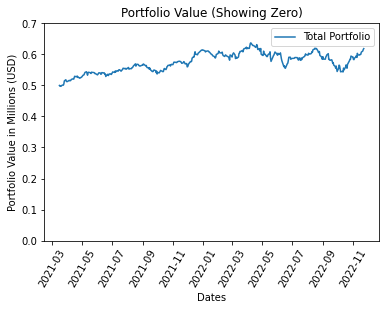

In [152]:
#Because otherwise the graph will automatically be in scientific notation, which is not 
interval = ['Millions', 1000000] #First element is the name, second element is the number

#Graph the selected portfolio value
plt.plot(selected_portfolio.index, selected_portfolio['total'] / interval[1], label='Total Portfolio')

plt.title('Portfolio Value (Showing Zero)')
plt.xlabel('Dates')
plt.xticks(rotation=60)
plt.ylabel('Portfolio Value in ' + interval[0] + ' (USD)')
#Show zero so that we can get a more accurate idea of how much the portfolio value changed overall, in the grand 
# scheme of things
plt.ylim([0, max(selected_portfolio['total'] / interval[1]) + 0.1 * max(selected_portfolio['total'] / interval[1])])
plt.legend(loc='best')

plt.show()

In [153]:
corr_prices = pd.DataFrame() 

for i in range (len(corr_tickers)):
    corr_prices[corr_tickers[i]] = all_prices[corr_tickers[i]]
corr_prices

corr_portfolio

,0,1,2,3,4,5,MON,NEE,OXY,PG,SLB,USB,total
Date,,,,,,,,,,,,,
2021-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
# Monte Carlo Simulation
# Input: list with both weighted portfolio historical prices
def monte_carlo(portfolio_value):
    daily_returns = np.diff(portfolio_value)/100
    daily_volatility = portfolio_value.std()

    num_simulations =  2000
    df = pd.DataFrame()

    trading_days = 5
    price = portfolio_value[len(portfolio_value)-1]/200
    price_list = []

    for i in range(num_simulations): 
        for i in range(trading_days):
            if i == trading_days-1:
                price_list.append(price/2)
                price=0
                break
            price = price/200 * (1 + np.random.normal(0, daily_volatility))
            print(price)
        price = portfolio_value[len(portfolio_value)-1]/200
                
    mean_simulated_price = round(np.mean(price_list),2)

    return mean_simulated_price


303166.6971952878
59322579.10510706
6842221874.230547
-2004752580174.181
-669238.8314625585
-23051175.850172788
-555218986.5507724
60514580503.62183
-127149.229836826
-39393836.27488597
-8361276705.944129
-2374874913175.036
-539339.1940084451
42521478.21404695
-5541317889.163788
-579971877381.0107
495756.50749886874
89724160.83944958
7348649930.771638
-846928790170.025
-152237.80675635833
21166363.777338658
1638594727.2914698
-135256446749.01013
-558153.5508194226
4688561.652161385
206595270.08605146
28913882677.849773
998328.0398228172
179584139.2572136
-26591088016.125813
1905044348051.0781
831750.0541665958
-85210011.70230155
168680215.56566915
-27421766978.737377
-73475.27076171449
2562422.608557127
-363161139.4558345
-104688061472.15468
514182.61353811214
-106094979.3395684
-4743755493.902376
599493435276.0724
-478772.62192509754
43400029.41751813
-2419613633.2399855
-102556262902.80534
-101897.45312392725
-27838640.217600968
2577734924.5487933
437101908169.4927
-134789.3111151463

In [148]:
ranking_weight =[]
correlation_weight=[]
predicted_price=[]

count = 70
while count <= 95:
    ranking_weight.append(count/100)
    correlation_weight.append((100-count)/100)
    
    ranking_weighted_value = [x * count/100 for x in selected_portfolio['total']]
    correlation_weighted_value = [x * ((100-count)/100) for x in corr_portfolio['total']]

    predicted_price.append(monte_carlo(np.add(ranking_weighted_value, correlation_weighted_value)))

    count += 5
# Create a dataframe to store Monte Carlo values
monte_carlo_df = pd.DataFrame()

# Convert python lists to numpy arrays
ranking_weight_array = np.array(ranking_weight) 
correlation_weight_array = np.array(correlation_weight)
predicted_price_array = np.array(predicted_price)

# Populating the dataframe storing sharpe ratio values and weightings
monte_carlo_df['Correlation Stocks Percentage'] = ranking_weight_array*100
monte_carlo_df['SD/Beta Stocks Percentage'] = correlation_weight_array*100
monte_carlo_df['Monte Carlo Prediction'] = predicted_price_array

monte_carlo_df

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


,Correlation Stocks Percentage,SD/Beta Stocks Percentage,Monte Carlo Prediction
0,70.0,30.0,NaN
1,75.0,25.0,NaN
2,80.0,20.0,NaN
3,85.0,15.0,NaN
4,90.0,10.0,NaN
5,95.0,5.0,NaN


In [110]:
def get_min_absvalue(values):
    return min(values, key = abs)
    
values = monte_carlo_df.iloc[:,2]
min_absvalue = get_min_absvalue(values)

# Printing the weighting with the least nomial change in portfolio value
monte_carlo_df.loc[monte_carlo_df['Monte Carlo Prediction'] == min_absvalue]

,Correlation Stocks Percentage,SD/Beta Stocks Percentage,Monte Carlo Prediction
2,80.0,20.0,-9.640136e+17


In [111]:
corr_stock_weighting = monte_carlo_df['Correlation Stocks Percentage']
stat_stock_weighting = monte_carlo_df['SD/Beta Stocks Percentage']

corr_portfolio = pd.DataFrame()
corr_ticker_cost = investment / (corr_stocks_number * 2)
corr_shares_per_stock = []

for i in range (len(corr_tickers)):
    corr_shares_per_stock.append(corr_ticker_cost / corr_prices.iloc[0, i])
    corr_portfolio[corr_tickers[i]] = corr_shares_per_stock[i] * corr_prices[corr_tickers[i]]

corr_portfolio['total'] = corr_portfolio.sum('columns')

corr_portfolio

,MON,USB,PG,OXY,NEE,SLB,total
Date,,,,,,,
2021-03-16,83333.333333,83333.333333,83333.333333,83333.333333,83333.333333,83333.333333,500000.000000
2021-03-17,82439.111362,84339.401818,82997.254417,85907.002965,80657.976791,84075.789670,500416.537023
2021-03-18,83205.591979,87094.473465,83178.210877,78748.086051,78634.892194,80927.775499,491789.030065
2021-03-19,83035.259343,85453.819515,82732.266643,83126.264764,78314.304832,80333.801146,492995.716243
2021-03-22,82609.435876,83952.452883,84134.722975,81232.982778,79253.986069,82115.706798,493299.287379
...,...,...,...,...,...,...,...
2022-11-17,85121.785398,70317.228636,95077.125392,212955.046397,93839.142580,160707.834174,718018.162577
2022-11-18,85121.785398,71320.117388,96224.511488,212329.236638,94807.729021,162563.432518,722366.812451
2022-11-21,85121.785398,71336.555412,97446.129794,207382.327019,95263.536460,159004.320930,715554.655013


In [112]:
corr_portfolio = corr_portfolio * corr_stock_weighting
selected_portfolio = selected_portfolio * stat_stock_weighting

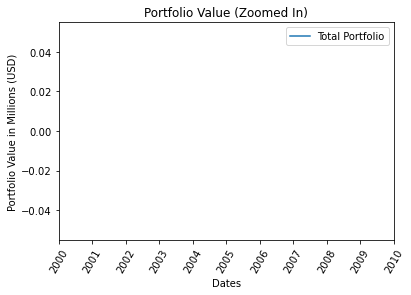

In [113]:
#Graph the selected portfolio value
plt.plot(selected_portfolio.index, selected_portfolio['total'] / interval[1], label='Total Portfolio')

plt.title('Portfolio Value (Zoomed In)')
plt.xlabel('Dates')
plt.xticks(rotation=60)
plt.ylabel('Portfolio Value in ' + interval[0] + ' (USD)')
plt.legend(loc='best')

plt.show()

In [114]:
def combine_portfolios(df1, df2, df1_tickers, df2_tickers):
    #Prioritize df1, that's the one we definitely keep all the stocks from, df2 used to supplement
    final_df = pd.DataFrame()
    count = 0
    for i in range (max_stocks):
        if i < len(df1_tickers):
            final_df[df1_tickers[i]] = df1[df1_tickers[i]]
        else:
            final_df[df2_tickers[count]] = df2[df2_tickers[count]]
            count += 1

    return final_df

In [115]:
final_portfolio = combine_portfolios(corr_prices, selected_portfolio, corr_tickers, selected_tickers)
final_tickers = list(final_portfolio.columns)

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.